Generated synthetic parameters:
        s_B  alpha_BW  beta1_BN  beta2_BkuadratH   rho2_BT       rBW  \
0  0.109934  0.143385  0.160734         0.083420  0.136223  0.355571   
1  0.097235  0.183174  0.166824         0.088796  0.176025  0.414565   
2  0.112954  0.186291  0.182492         0.114946  0.200210  0.216086   
3  0.130461  0.167909  0.181614         0.112207  0.201879  0.333778   
4  0.095317  0.193549  0.108670         0.099582  0.181997  0.260961   

      v1_WN     v2_WH    thetaN  lambda_beta1_BN  ...    phi0_p   phi1_EP  \
0  0.115140  0.089546  0.237531         0.107373  ...  0.102504  0.086638   
1  0.081557  0.120980  0.179358         0.092133  ...  0.091412  0.119841   
2  0.117392  0.085913  0.203845         0.100575  ...  0.102446  0.096501   
3  0.127113  0.071831  0.181509         0.125569  ...  0.110866  0.084885   
4  0.108269  0.068867  0.182620         0.103822  ...  0.100977  0.110730   

    gamma_N  pi_beta2_BkuadratH    phi2_P  gamma1_H       rho    rho1_T 

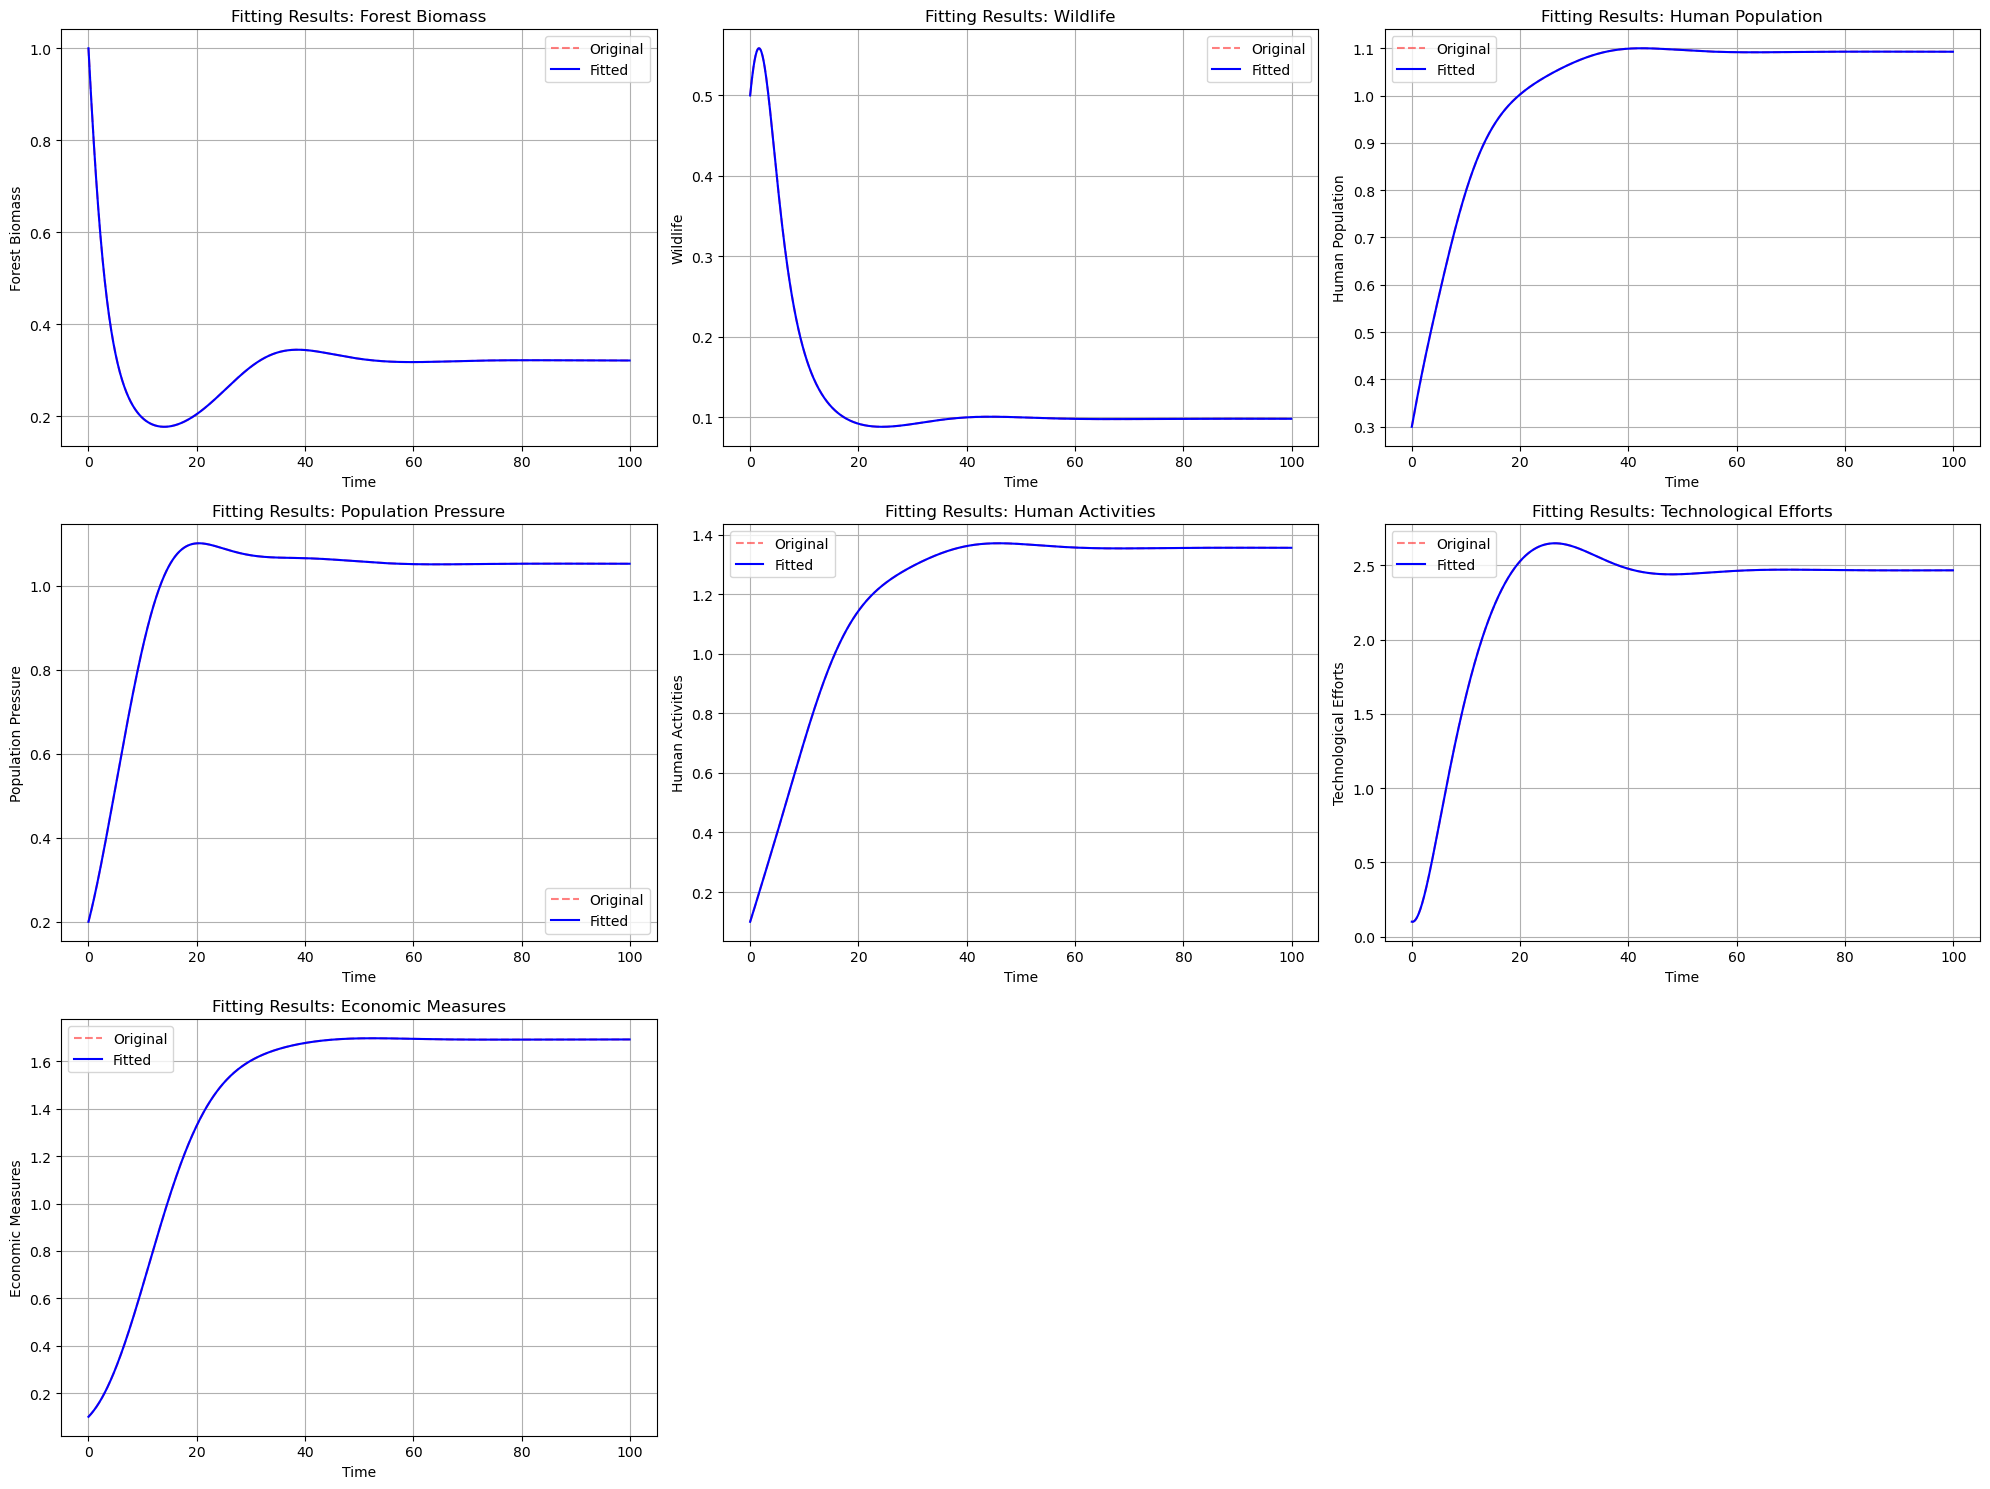

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Model persamaan diferensial
def model_forest_biomass(X, t, params):
    Y = np.zeros(7)
    
    # Parameter assignments
    s_B = params[0]
    alpha_BW = params[1]
    beta1_BN = params[2]
    beta2_BkuadratH = params[3]
    rho2_BT = params[4]
    rBW = params[5]
    v1_WN = params[6]
    v2_WH = params[7]
    thetaN = params[8]
    lambda_beta1_BN = params[9]
    sigma_NW = params[10]
    phi_N = params[11]
    phi0_p = params[12]
    phi1_EP = params[13]
    gamma_N = params[14]
    pi_beta2_BkuadratH = params[15]
    phi2_P = params[16]
    gamma1_H = params[17]
    rho = params[18]
    rho1_T = params[19]
    omega_P = params[20]
    omega1_E = params[21]
    
    # Persamaan diferensial
    Y[0] = -s_B*X[0] - alpha_BW*X[0]*X[1] - beta1_BN*X[0]*X[2] - beta2_BkuadratH*X[0]*X[0]*X[4] + rho2_BT*X[0]*X[5]
    Y[1] = rBW*X[1]*(1 - X[1]/X[0]) - v1_WN*X[1]*X[2] - v2_WH*X[1]*X[4]
    Y[2] = thetaN*X[2]*(1 - X[2]) + lambda_beta1_BN*X[0]*X[2] - sigma_NW*X[2]*X[1]
    Y[3] = phi_N*X[2] - phi0_p*X[3] - phi1_EP*X[3]*X[6]
    Y[4] = gamma_N*X[2] + pi_beta2_BkuadratH*X[0]*X[0]*X[4] + phi2_P*X[3] - gamma1_H*X[4]
    Y[5] = rho*(1 - X[0]) - rho1_T*X[5]
    Y[6] = omega_P*X[3] - omega1_E*X[6]
    
    return Y

def generate_gaussian_params(n_samples=100):
    """Generate synthetic parameter data using Gaussian distribution"""
    np.random.seed(42)
    
    # Define parameter means based on original values
    param_means = [
        0.1,  # s_B
        0.2,  # alpha_BW
        0.15, # beta1_BN
        0.1,  # beta2_BkuadratH
        0.2,  # rho2_BT
        0.3,  # rBW
        0.1,  # v1_WN
        0.1,  # v2_WH
        0.2,  # thetaN
        0.1,  # lambda_beta1_BN
        0.1,  # sigma_NW
        0.2,  # phi_N
        0.1,  # phi0_p
        0.1,  # phi1_EP
        0.2,  # gamma_N
        0.1,  # pi_beta2_BkuadratH
        0.1,  # phi2_P
        0.2,  # gamma1_H
        0.3,  # rho
        0.1,  # rho1_T
        0.2,  # omega_P
        0.1   # omega1_E
    ]
    
    param_stds = [mean * 0.2 for mean in param_means]
    
    # Generate parameters
    params_data = np.zeros((n_samples, len(param_means)))
    for i in range(len(param_means)):
        params_data[:, i] = np.maximum(0.01, np.random.normal(
            param_means[i], 
            param_stds[i], 
            n_samples
        ))
    
    param_names = [
        's_B', 'alpha_BW', 'beta1_BN', 'beta2_BkuadratH', 'rho2_BT',
        'rBW', 'v1_WN', 'v2_WH', 'thetaN', 'lambda_beta1_BN',
        'sigma_NW', 'phi_N', 'phi0_p', 'phi1_EP', 'gamma_N',
        'pi_beta2_BkuadratH', 'phi2_P', 'gamma1_H', 'rho',
        'rho1_T', 'omega_P', 'omega1_E'
    ]
    
    df_params = pd.DataFrame(params_data, columns=param_names)
    return df_params

# Generate synthetic parameters
synthetic_params = generate_gaussian_params()
print("Generated synthetic parameters:")
print(synthetic_params.head())

# Objective function for fitting all parameters
def objective_function(params, times, observed_data):
    """Calculate error between model prediction and observed data"""
    try:
        X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1]
        
        prediction = odeint(model_forest_biomass, X0, times, args=(tuple(params),))
        
        error = np.mean((prediction - observed_data) ** 2)
        return error
    except:
        return float('inf')

# Function to fit parameters
def fit_parameters(times, observed_data, initial_params):
    bounds = [(0.001, None) for _ in initial_params]
    
    result = minimize(
        objective_function,
        initial_params,
        args=(times, observed_data),
        method='L-BFGS-B',
        bounds=bounds
    )
    
    return result.x

t_start = 0
t_end = 100
dt = 0.1
times = np.arange(t_start, t_end, dt)

# Generate observed data using initial parameters
X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1]
initial_params = synthetic_params.iloc[0].values
observed_data = odeint(model_forest_biomass, X0, times, args=(tuple(initial_params),))

fitted_params = fit_parameters(times, observed_data, initial_params)

variables = [
    'Forest Biomass', 'Wildlife', 'Human Population', 
    'Population Pressure', 'Human Activities',
    'Technological Efforts', 'Economic Measures'
]

plt.figure(figsize=(20, 15))
for i in range(7):
    plt.subplot(3, 3, i+1)
    
    # Original data
    plt.plot(times, observed_data[:, i], 'r--', label='Original', alpha=0.5)
    
    # Fitted data
    fitted_solution = odeint(model_forest_biomass, X0, times, args=(tuple(fitted_params),))
    plt.plot(times, fitted_solution[:, i], 'b-', label='Fitted')
    
    plt.xlabel('Time')
    plt.ylabel(variables[i])
    plt.title(f'Fitting Results: {variables[i]}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Generated uniform parameters:
        s_B  alpha_BW  beta1_BN  beta2_BkuadratH   rho2_BT       rBW  \
0  0.087454  0.106286  0.171305         0.055168  0.120625  0.359449   
1  0.145071  0.227282  0.087621         0.103135  0.280511  0.310829   
2  0.123199  0.162871  0.099244         0.104064  0.201050  0.242858   
3  0.109866  0.201714  0.209783         0.113743  0.265291  0.394139   
4  0.065602  0.281513  0.165964         0.122609  0.164010  0.355419   

      v1_WN     v2_WH    thetaN  lambda_beta1_BN  ...    phi0_p   phi1_EP  \
0  0.066894  0.103259  0.241448         0.070789  ...  0.125826  0.053159   
1  0.077859  0.055182  0.130508         0.052653  ...  0.052459  0.143621   
2  0.067701  0.083660  0.215258         0.068144  ...  0.052212  0.055197   
3  0.058870  0.063441  0.221343         0.108304  ...  0.082361  0.104130   
4  0.062064  0.056337  0.184826         0.092142  ...  0.098864  0.120906   

    gamma_N  pi_beta2_BkuadratH    phi2_P  gamma1_H       rho    rho1_T  \

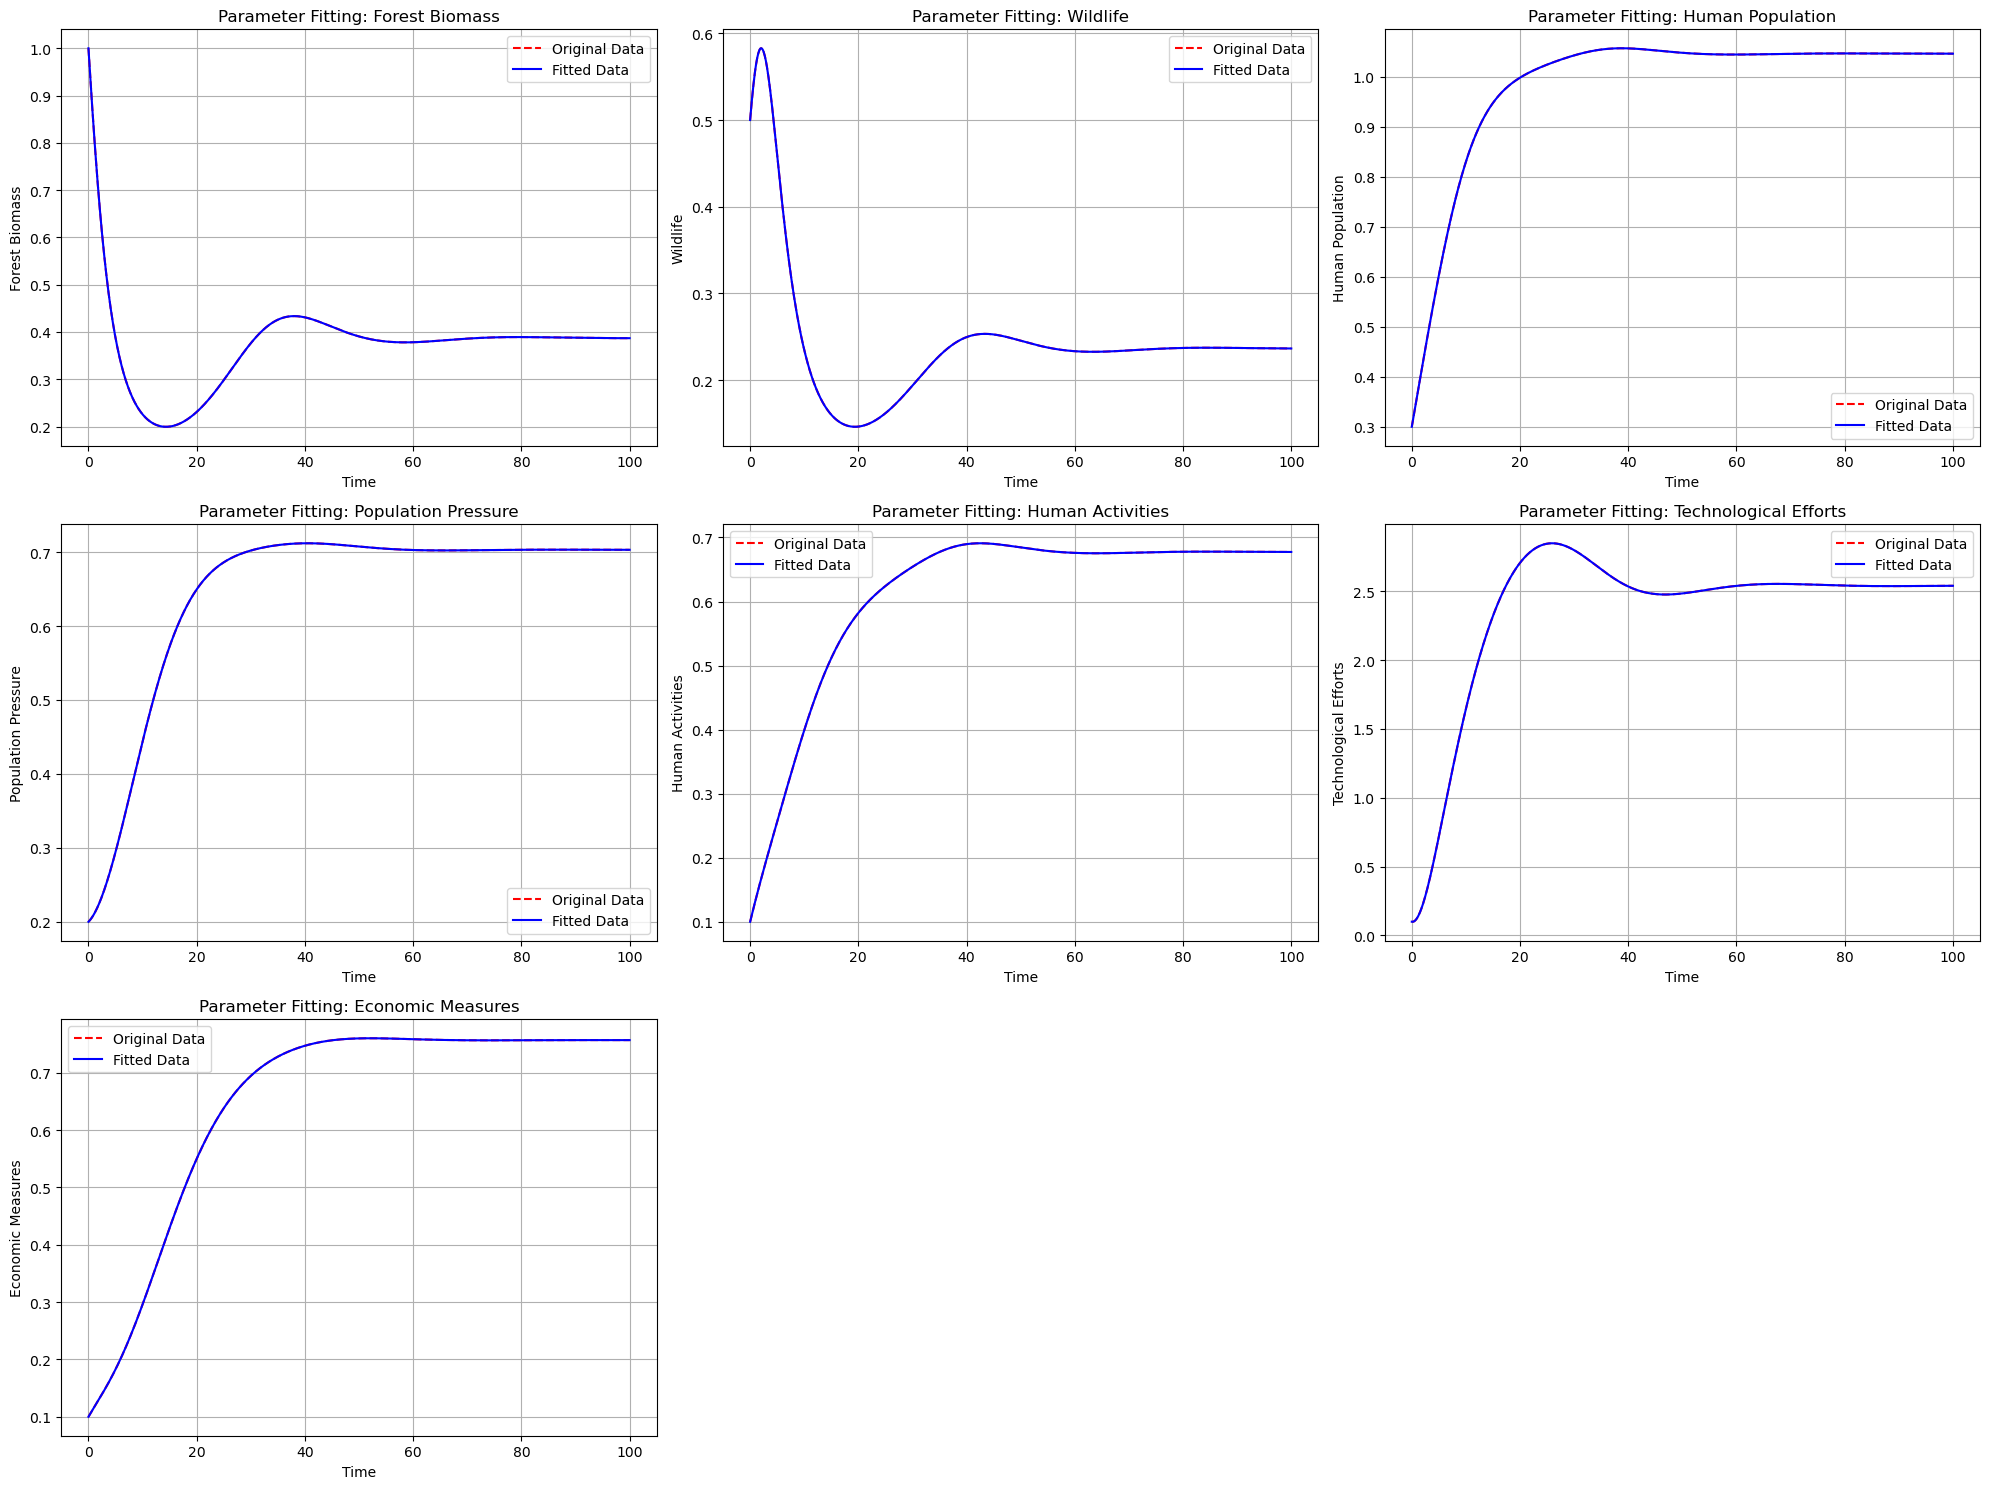

In [2]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def model_forest_biomass(X, t, params):
    Y = np.zeros(7)
    
    # Parameter assignments
    s_B = params[0]
    alpha_BW = params[1]
    beta1_BN = params[2]
    beta2_BkuadratH = params[3]
    rho2_BT = params[4]
    rBW = params[5]
    v1_WN = params[6]
    v2_WH = params[7]
    thetaN = params[8]
    lambda_beta1_BN = params[9]
    sigma_NW = params[10]
    phi_N = params[11]
    phi0_p = params[12]
    phi1_EP = params[13]
    gamma_N = params[14]
    pi_beta2_BkuadratH = params[15]
    phi2_P = params[16]
    gamma1_H = params[17]
    rho = params[18]
    rho1_T = params[19]
    omega_P = params[20]
    omega1_E = params[21]
    
    # Differential equations
    Y[0] = -s_B*X[0] - alpha_BW*X[0]*X[1] - beta1_BN*X[0]*X[2] - beta2_BkuadratH*X[0]*X[0]*X[4] + rho2_BT*X[0]*X[5]
    Y[1] = rBW*X[1]*(1 - X[1]/X[0]) - v1_WN*X[1]*X[2] - v2_WH*X[1]*X[4]
    Y[2] = thetaN*X[2]*(1 - X[2]) + lambda_beta1_BN*X[0]*X[2] - sigma_NW*X[2]*X[1]
    Y[3] = phi_N*X[2] - phi0_p*X[3] - phi1_EP*X[3]*X[6]
    Y[4] = gamma_N*X[2] + pi_beta2_BkuadratH*X[0]*X[0]*X[4] + phi2_P*X[3] - gamma1_H*X[4]
    Y[5] = rho*(1 - X[0]) - rho1_T*X[5]
    Y[6] = omega_P*X[3] - omega1_E*X[6]
    
    return Y

def generate_uniform_params(n_samples=100):
    np.random.seed(42)
    param_ranges = [
        (0.05, 0.15),   # s_B
        (0.1, 0.3),     # alpha_BW
        (0.075, 0.225), # beta1_BN
        (0.05, 0.15),   # beta2_BkuadratH
        (0.1, 0.3),     # rho2_BT
        (0.15, 0.45),   # rBW
        (0.05, 0.15),   # v1_WN
        (0.05, 0.15),   # v2_WH
        (0.1, 0.3),     # thetaN
        (0.05, 0.15),   # lambda_beta1_BN
        (0.05, 0.15),   # sigma_NW
        (0.1, 0.3),     # phi_N
        (0.05, 0.15),   # phi0_p
        (0.05, 0.15),   # phi1_EP
        (0.1, 0.3),     # gamma_N
        (0.05, 0.15),   # pi_beta2_BkuadratH
        (0.05, 0.15),   # phi2_P
        (0.1, 0.3),     # gamma1_H
        (0.15, 0.45),   # rho
        (0.05, 0.15),   # rho1_T
        (0.1, 0.3),     # omega_P
        (0.05, 0.15)    # omega1_E
    ]
    
    params_data = np.zeros((n_samples, len(param_ranges)))
    for i, (min_val, max_val) in enumerate(param_ranges):
        params_data[:, i] = np.random.uniform(min_val, max_val, n_samples)
    
    param_names = [
        's_B', 'alpha_BW', 'beta1_BN', 'beta2_BkuadratH', 'rho2_BT',
        'rBW', 'v1_WN', 'v2_WH', 'thetaN', 'lambda_beta1_BN',
        'sigma_NW', 'phi_N', 'phi0_p', 'phi1_EP', 'gamma_N',
        'pi_beta2_BkuadratH', 'phi2_P', 'gamma1_H', 'rho',
        'rho1_T', 'omega_P', 'omega1_E'
    ]
    
    return pd.DataFrame(params_data, columns=param_names)

def objective_function(params, times, observed_data):
    try:
        X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1]
        prediction = odeint(model_forest_biomass, X0, times, args=(tuple(params),))
        error = np.mean((prediction - observed_data) ** 2)
        return error
    except:
        return float('inf')

# Generate and fit data
if __name__ == "__main__":
    uniform_params = generate_uniform_params()
    print("Generated uniform parameters:")
    print(uniform_params.head())
    
    times = np.linspace(0, 100, 1000)
    
    # Generate synthetic data using first set of parameters
    X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1]
    initial_params = uniform_params.iloc[0].values
    synthetic_data = odeint(model_forest_biomass, X0, times, args=(tuple(initial_params),))
    
    # Fit parameters
    bounds = [(0.001, None) for _ in initial_params]
    fitted_result = minimize(
        objective_function,
        initial_params,
        args=(times, synthetic_data),
        method='L-BFGS-B',
        bounds=bounds
    )
    
    fitted_params = fitted_result.x
    
    fitted_solution = odeint(model_forest_biomass, X0, times, args=(tuple(fitted_params),))
    
    # Plot results
    variables = [
        'Forest Biomass', 'Wildlife', 'Human Population', 
        'Population Pressure', 'Human Activities',
        'Technological Efforts', 'Economic Measures'
    ]
    
    plt.figure(figsize=(20, 15))
    for i in range(7):
        plt.subplot(3, 3, i+1)
        plt.plot(times, synthetic_data[:, i], 'r--', label='Original Data')
        plt.plot(times, fitted_solution[:, i], 'b-', label='Fitted Data')
        plt.xlabel('Time')
        plt.ylabel(variables[i])
        plt.title(f'Parameter Fitting: {variables[i]}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

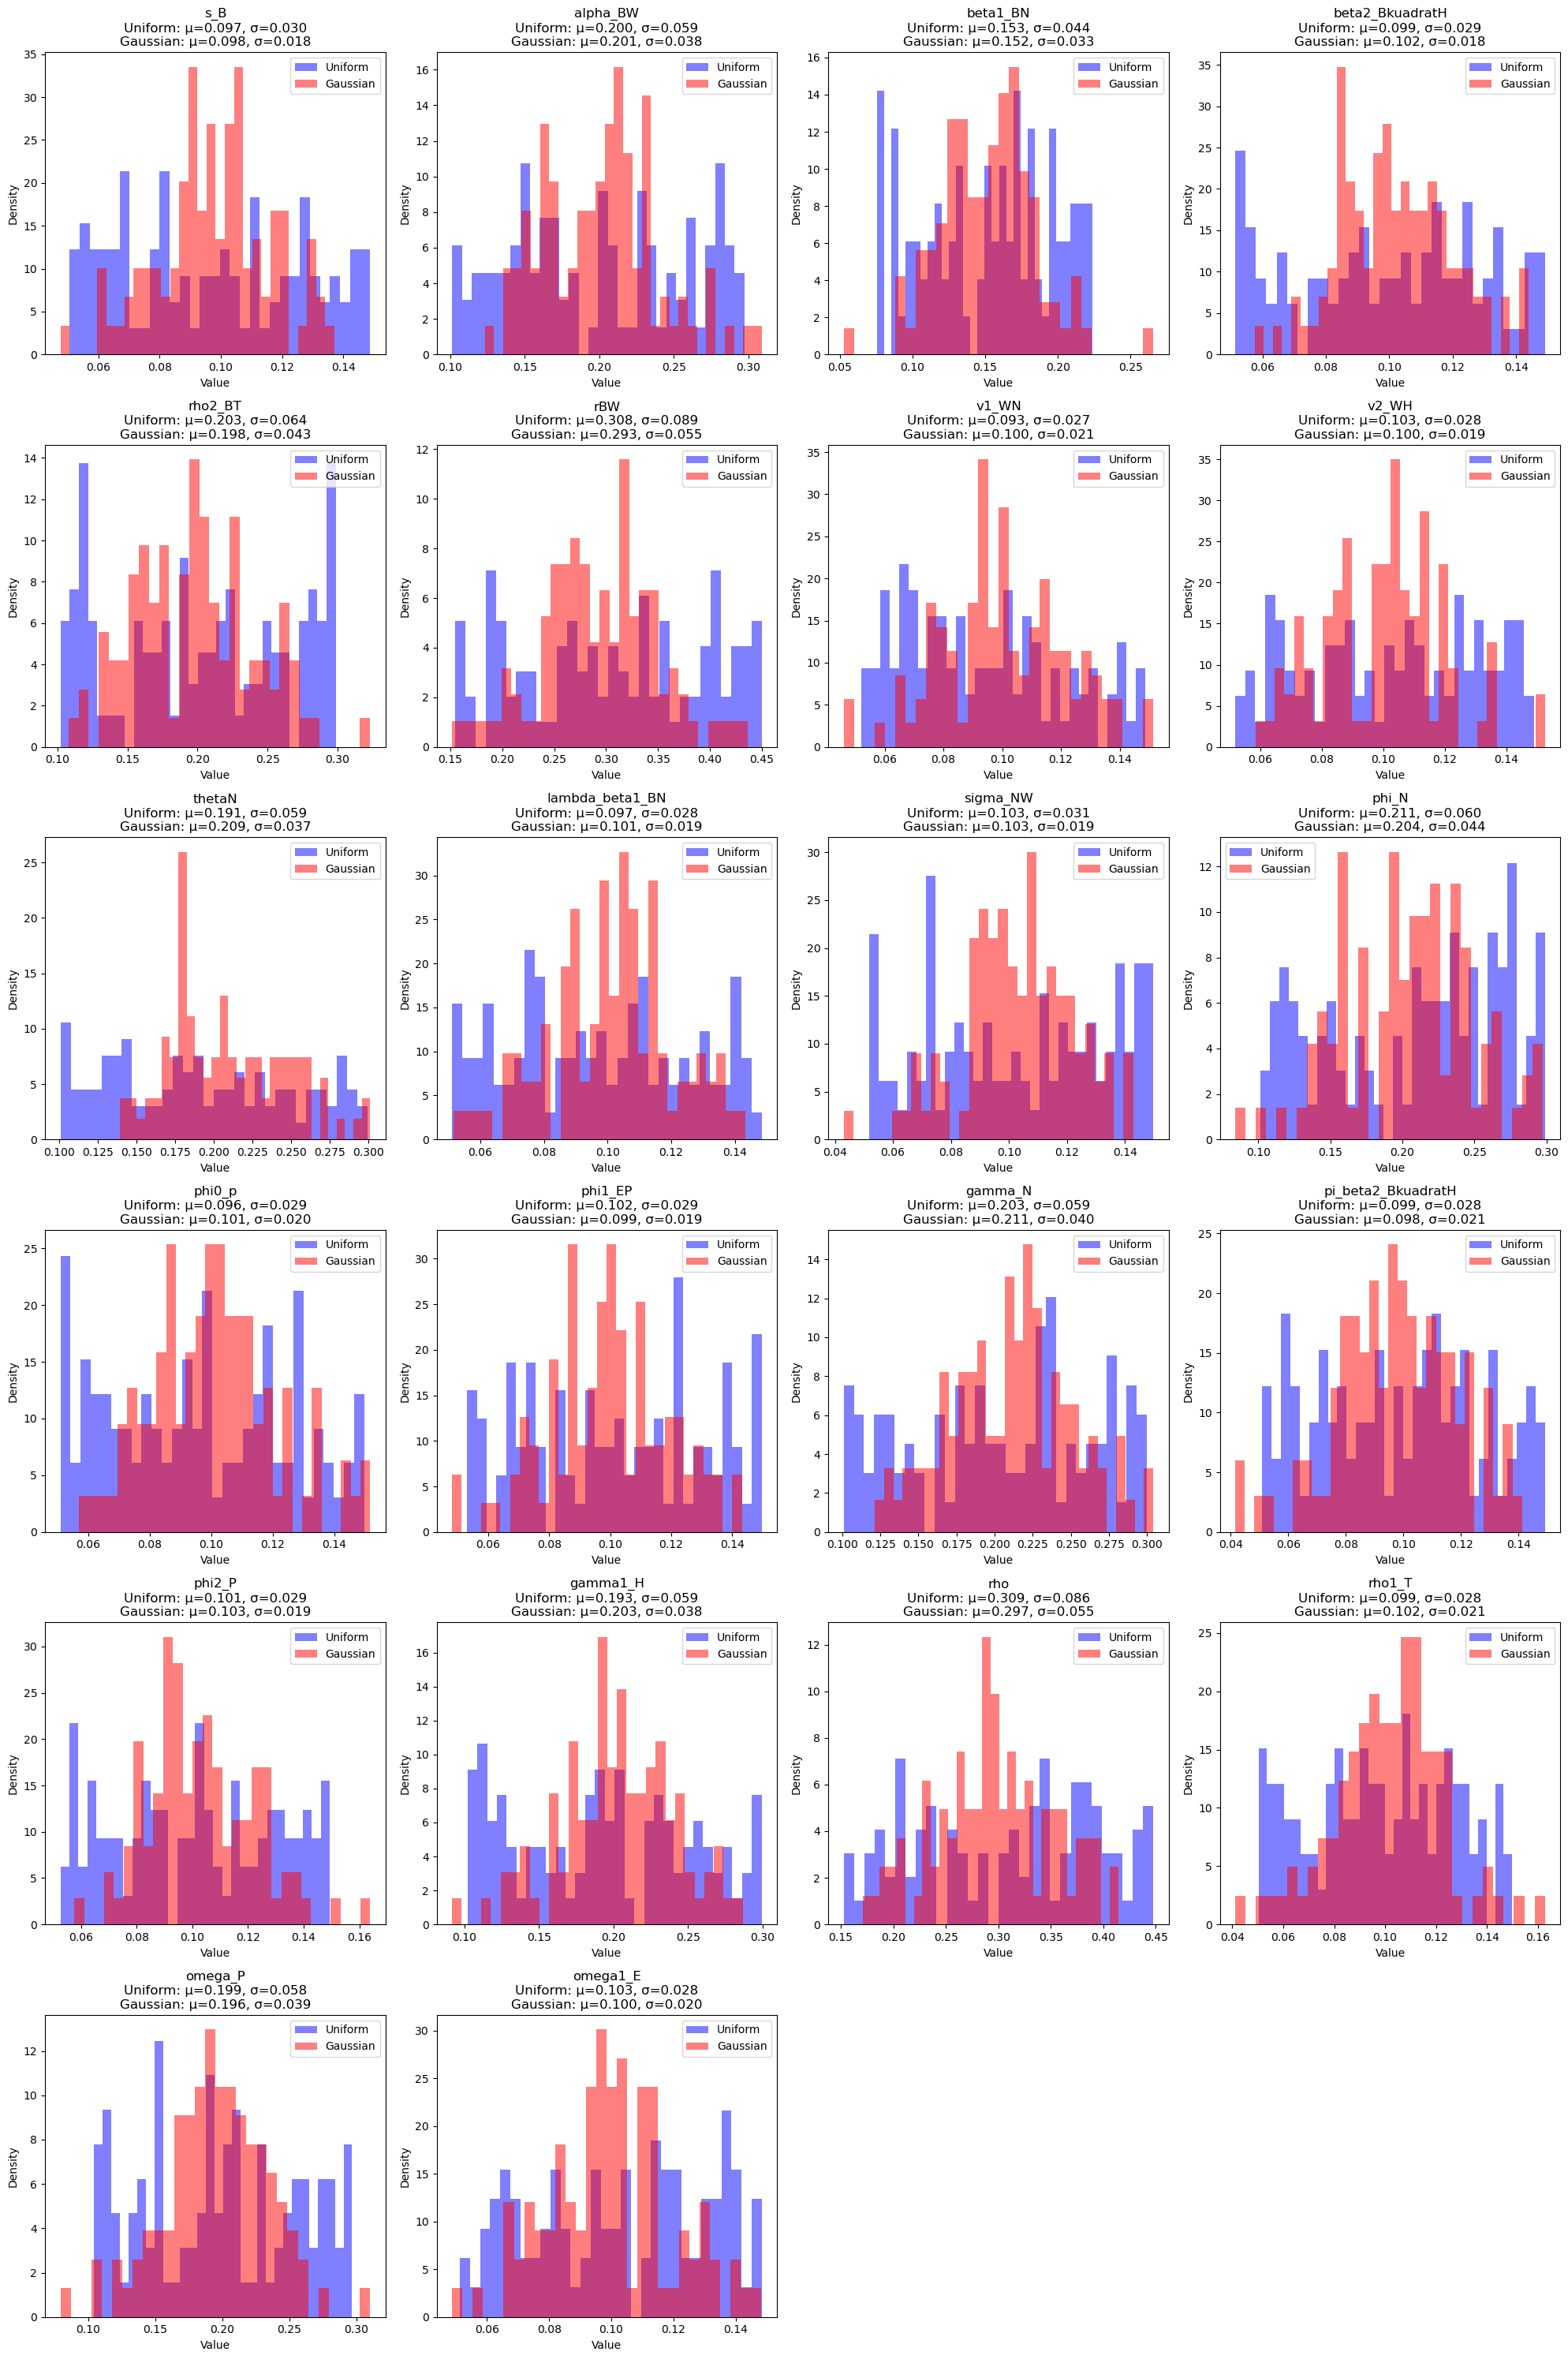


Statistical Comparison Results:
                    KS_statistic   p_value  Mean_Diff  Std_Diff
s_B                         0.23  0.009878  -0.000905  0.011586
alpha_BW                    0.20  0.036384  -0.001326  0.020475
beta1_BN                    0.18  0.078221   0.000693  0.011485
beta2_BkuadratH             0.24  0.006134  -0.003022  0.011663
rho2_BT                     0.20  0.036384   0.005449  0.021171
rBW                         0.25  0.003729   0.014508  0.033724
v1_WN                       0.25  0.003729  -0.007323  0.005390
v2_WH                       0.25  0.003729   0.002719  0.008844
thetaN                      0.31  0.000120  -0.018001  0.021161
lambda_beta1_BN             0.21  0.024056  -0.003438  0.008475
sigma_NW                    0.25  0.003729   0.000129  0.011803
phi_N                       0.21  0.024056   0.006511  0.015592
phi0_p                      0.23  0.009878  -0.004682  0.009045
phi1_EP                     0.19  0.053902   0.002855  0.009483
gamma_N

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def generate_uniform_params(n_samples=100):
    np.random.seed(42)
    param_ranges = [
        (0.05, 0.15),   # s_B
        (0.1, 0.3),     # alpha_BW
        (0.075, 0.225), # beta1_BN
        (0.05, 0.15),   # beta2_BkuadratH
        (0.1, 0.3),     # rho2_BT
        (0.15, 0.45),   # rBW
        (0.05, 0.15),   # v1_WN
        (0.05, 0.15),   # v2_WH
        (0.1, 0.3),     # thetaN
        (0.05, 0.15),   # lambda_beta1_BN
        (0.05, 0.15),   # sigma_NW
        (0.1, 0.3),     # phi_N
        (0.05, 0.15),   # phi0_p
        (0.05, 0.15),   # phi1_EP
        (0.1, 0.3),     # gamma_N
        (0.05, 0.15),   # pi_beta2_BkuadratH
        (0.05, 0.15),   # phi2_P
        (0.1, 0.3),     # gamma1_H
        (0.15, 0.45),   # rho
        (0.05, 0.15),   # rho1_T
        (0.1, 0.3),     # omega_P
        (0.05, 0.15)    # omega1_E
    ]
    
    params_data = np.zeros((n_samples, len(param_ranges)))
    for i, (min_val, max_val) in enumerate(param_ranges):
        params_data[:, i] = np.random.uniform(min_val, max_val, n_samples)
    
    param_names = [
        's_B', 'alpha_BW', 'beta1_BN', 'beta2_BkuadratH', 'rho2_BT',
        'rBW', 'v1_WN', 'v2_WH', 'thetaN', 'lambda_beta1_BN',
        'sigma_NW', 'phi_N', 'phi0_p', 'phi1_EP', 'gamma_N',
        'pi_beta2_BkuadratH', 'phi2_P', 'gamma1_H', 'rho',
        'rho1_T', 'omega_P', 'omega1_E'
    ]
    
    return pd.DataFrame(params_data, columns=param_names)

def generate_gaussian_params(n_samples=100):
    np.random.seed(42)
    param_means = [
        0.1,  # s_B
        0.2,  # alpha_BW
        0.15, # beta1_BN
        0.1,  # beta2_BkuadratH
        0.2,  # rho2_BT
        0.3,  # rBW
        0.1,  # v1_WN
        0.1,  # v2_WH
        0.2,  # thetaN
        0.1,  # lambda_beta1_BN
        0.1,  # sigma_NW
        0.2,  # phi_N
        0.1,  # phi0_p
        0.1,  # phi1_EP
        0.2,  # gamma_N
        0.1,  # pi_beta2_BkuadratH
        0.1,  # phi2_P
        0.2,  # gamma1_H
        0.3,  # rho
        0.1,  # rho1_T
        0.2,  # omega_P
        0.1   # omega1_E
    ]
    
    param_stds = [mean * 0.2 for mean in param_means]
    
    params_data = np.zeros((n_samples, len(param_means)))
    for i in range(len(param_means)):
        params_data[:, i] = np.maximum(0.01, np.random.normal(
            param_means[i], 
            param_stds[i], 
            n_samples
        ))
    
    param_names = [
        's_B', 'alpha_BW', 'beta1_BN', 'beta2_BkuadratH', 'rho2_BT',
        'rBW', 'v1_WN', 'v2_WH', 'thetaN', 'lambda_beta1_BN',
        'sigma_NW', 'phi_N', 'phi0_p', 'phi1_EP', 'gamma_N',
        'pi_beta2_BkuadratH', 'phi2_P', 'gamma1_H', 'rho',
        'rho1_T', 'omega_P', 'omega1_E'
    ]
    
    return pd.DataFrame(params_data, columns=param_names)

def compare_distributions(uniform_params, gaussian_params):
    param_names = uniform_params.columns
    
    n_params = len(param_names)
    n_cols = 4
    n_rows = (n_params + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5*n_rows))
    
    for i, param in enumerate(param_names):
        plt.subplot(n_rows, n_cols, i+1)
        
        # Plot histograms
        plt.hist(uniform_params[param], bins=30, alpha=0.5, 
                color='blue', label='Uniform', density=True)
        plt.hist(gaussian_params[param], bins=30, alpha=0.5, 
                color='red', label='Gaussian', density=True)
        
        uni_mean = uniform_params[param].mean()
        uni_std = uniform_params[param].std()
        gauss_mean = gaussian_params[param].mean()
        gauss_std = gaussian_params[param].std()
        
        plt.title(f'{param}\nUniform: μ={uni_mean:.3f}, σ={uni_std:.3f}\n'
                 f'Gaussian: μ={gauss_mean:.3f}, σ={gauss_std:.3f}')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Perform statistical tests
    stats_results = pd.DataFrame(columns=['KS_statistic', 'p_value', 
                                        'Mean_Diff', 'Std_Diff'])
    
    for param in param_names:
        # Kolmogorov-Smirnov test
        ks_stat, p_val = stats.ks_2samp(uniform_params[param], 
                                       gaussian_params[param])
        
        # Mean and std differences
        mean_diff = uniform_params[param].mean() - gaussian_params[param].mean()
        std_diff = uniform_params[param].std() - gaussian_params[param].std()
        
        stats_results.loc[param] = [ks_stat, p_val, mean_diff, std_diff]
    
    return stats_results

if __name__ == "__main__":
    uniform_params = generate_uniform_params()
    gaussian_params = generate_gaussian_params()
    stats_results = compare_distributions(uniform_params, gaussian_params)
    
    # Print statistical results
    print("\nStatistical Comparison Results:")
    print(stats_results)
    stats_results.to_csv('distribution_comparison_results.csv')
    uniform_params.to_csv('uniform_params.csv', index=False)
    gaussian_params.to_csv('gaussian_params.csv', index=False)

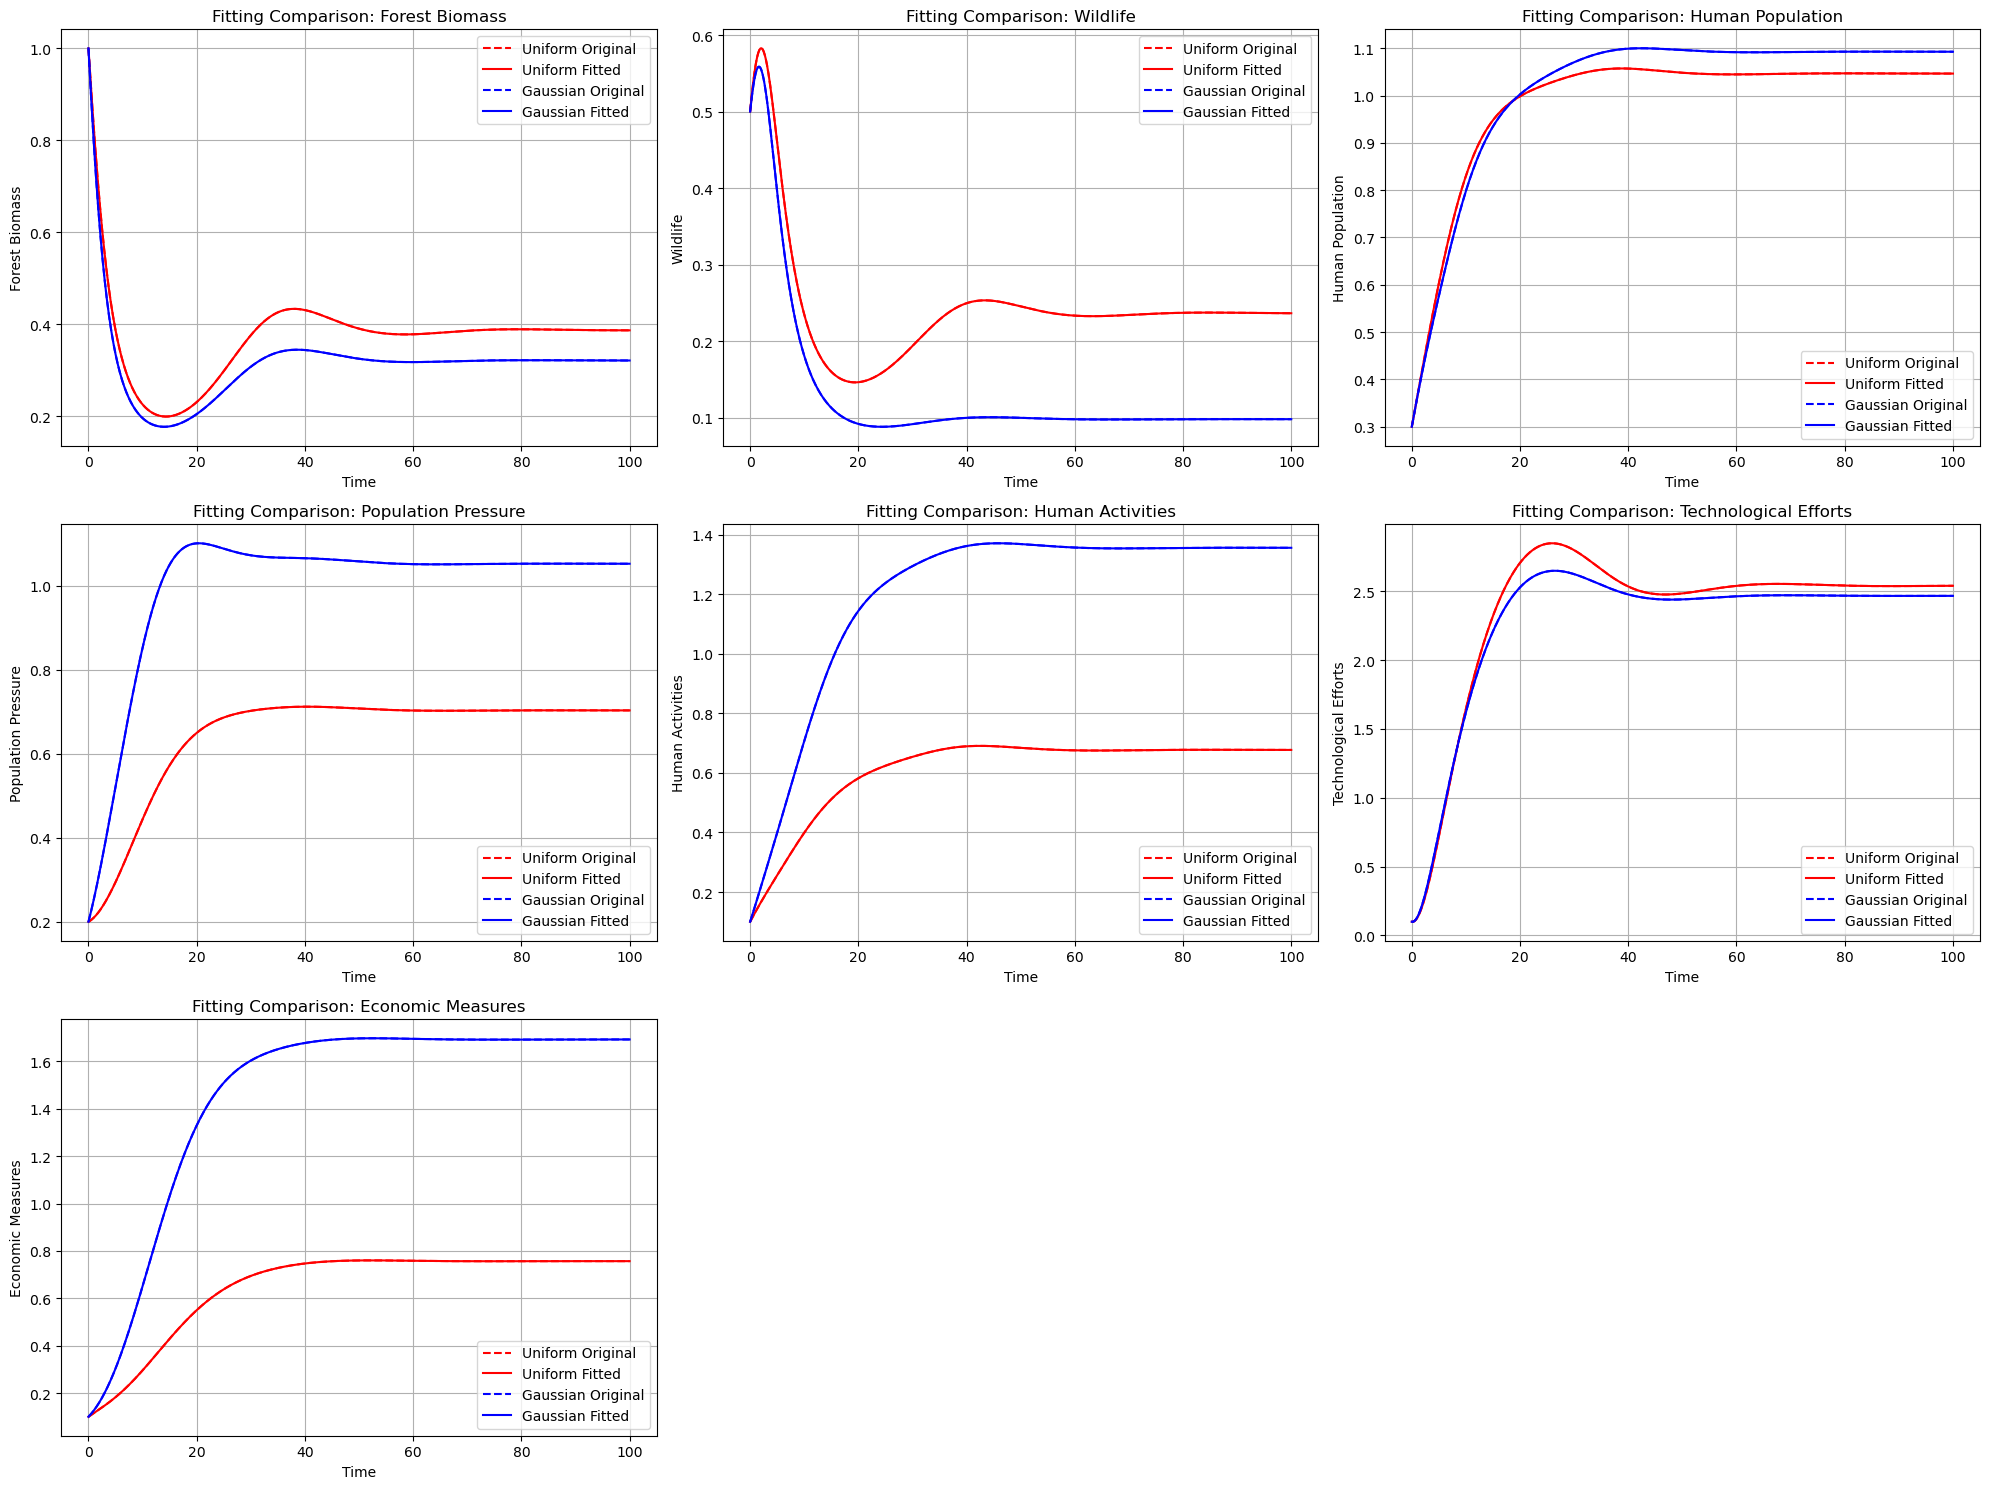


Parameter Comparison:

Original vs Fitted Parameters:

Uniform Distribution:
s_B: 0.0875 -> 0.0875
alpha_BW: 0.1063 -> 0.1063
beta1_BN: 0.1713 -> 0.1713
beta2_BkuadratH: 0.0552 -> 0.0552
rho2_BT: 0.1206 -> 0.1206
rBW: 0.3594 -> 0.3594
v1_WN: 0.0669 -> 0.0669
v2_WH: 0.1033 -> 0.1033
thetaN: 0.2414 -> 0.2414
lambda_beta1_BN: 0.0708 -> 0.0708
sigma_NW: 0.0685 -> 0.0685
phi_N: 0.1116 -> 0.1116
phi0_p: 0.1258 -> 0.1258
phi1_EP: 0.0532 -> 0.0532
gamma_N: 0.1334 -> 0.1334
pi_beta2_BkuadratH: 0.1019 -> 0.1019
phi2_P: 0.0692 -> 0.0692
gamma1_H: 0.2932 -> 0.2932
rho: 0.4370 -> 0.4370
rho1_T: 0.1054 -> 0.1054
omega_P: 0.1523 -> 0.1523
omega1_E: 0.1415 -> 0.1415

Gaussian Distribution:
s_B: 0.1099 -> 0.1099
alpha_BW: 0.1434 -> 0.1434
beta1_BN: 0.1607 -> 0.1607
beta2_BkuadratH: 0.0834 -> 0.0834
rho2_BT: 0.1362 -> 0.1362
rBW: 0.3556 -> 0.3556
v1_WN: 0.1151 -> 0.1151
v2_WH: 0.0895 -> 0.0895
thetaN: 0.2375 -> 0.2375
lambda_beta1_BN: 0.1074 -> 0.1074
sigma_NW: 0.1280 -> 0.1280
phi_N: 0.2399 -> 0.2399


In [4]:
def compare_fitting_results(uniform_params, gaussian_params, times):
    X0 = [1.0, 0.5, 0.3, 0.2, 0.1, 0.1, 0.1] #kondisi awal untuk perbandingan fitting data
    
    uniform_synthetic = odeint(model_forest_biomass, X0, times, 
                             args=(tuple(uniform_params.iloc[0].values),))
    gaussian_synthetic = odeint(model_forest_biomass, X0, times, 
                              args=(tuple(gaussian_params.iloc[0].values),))
    
    # parameter kedua metode di samain untuk perbandingan
    uniform_fitted = minimize(
        objective_function,
        uniform_params.iloc[0].values,
        args=(times, uniform_synthetic),
        method='L-BFGS-B',
        bounds=[(0.001, None) for _ in uniform_params.iloc[0]]
    ).x
    
    gaussian_fitted = minimize(
        objective_function,
        gaussian_params.iloc[0].values,
        args=(times, gaussian_synthetic),
        method='L-BFGS-B',
        bounds=[(0.001, None) for _ in gaussian_params.iloc[0]]
    ).x
    
    # Generate solutions with fitted parameters
    uniform_solution = odeint(model_forest_biomass, X0, times, 
                            args=(tuple(uniform_fitted),))
    gaussian_solution = odeint(model_forest_biomass, X0, times, 
                             args=(tuple(gaussian_fitted),))
    
    variables = [
        'Forest Biomass', 'Wildlife', 'Human Population', 
        'Population Pressure', 'Human Activities',
        'Technological Efforts', 'Economic Measures'
    ]
    
    plt.figure(figsize=(20, 15))
    for i in range(7):
        plt.subplot(3, 3, i+1)
        
        plt.plot(times, uniform_synthetic[:, i], 'r--', 
                label='Uniform Original')
        plt.plot(times, uniform_solution[:, i], 'r-', 
                label='Uniform Fitted')
        plt.plot(times, gaussian_synthetic[:, i], 'b--', 
                label='Gaussian Original')
        plt.plot(times, gaussian_solution[:, i], 'b-', 
                label='Gaussian Fitted')
        
        plt.xlabel('Time')
        plt.ylabel(variables[i])
        plt.title(f'Fitting Comparison: {variables[i]}')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return uniform_fitted, gaussian_fitted

if __name__ == "__main__":
    times = np.linspace(0, 100, 1000)
    
    # Compare hasil fitting 
    uniform_fitted, gaussian_fitted = compare_fitting_results(
        uniform_params, gaussian_params, times)
    
    print("\nParameter Comparison:")
    print("\nOriginal vs Fitted Parameters:")
    param_names = uniform_params.columns
    
    print("\nUniform Distribution:")
    for name, orig, fit in zip(param_names, 
                              uniform_params.iloc[0], 
                              uniform_fitted):
        print(f"{name}: {orig:.4f} -> {fit:.4f}")
    
    print("\nGaussian Distribution:")
    for name, orig, fit in zip(param_names, 
                              gaussian_params.iloc[0], 
                              gaussian_fitted):
        print(f"{name}: {orig:.4f} -> {fit:.4f}")